<a href="https://colab.research.google.com/github/Consmart18/Debiasing-Student-Algorithms/blob/main/RQ3_Bias_Mitigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Debiasing algorithms for student progress monitoring
### RQ2: Bias Mitigation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the data
projectdata_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project files/studentinfo_updated_150.csv')

In [ ]:
# drop student identifier
df = projectdata_df.drop(['id_student', 'score_tma3', 'score_tma4', 'score_tma5', 'sum_interaction_90',
                          'sum_interaction_120', 'sum_interaction_150',], axis=1)

In [ ]:
# fill missing values in imd_band and convert to label
mapping = {'0-10%': 1, '10-20%': 2, '20-30%': 3, '30-40%': 4, '40-50%': 5,
           '50-60%': 6, '60-70%': 7, '70-80%': 8, '80-90%': 9, '90-100%': 10}
df['imd_band'] = df['imd_band'].map(mapping)

# fill missing values with mode
df['imd_band'].fillna(df['imd_band'].mode()[0], inplace=True)

# convert age_band to label as well
mapping = {'0-35': 0, '35-55': 1, '55<=': 1}
df['age_band'] = df['age_band'].map(mapping)

In [ ]:
# One-hot encode the 'code_module' column
df = pd.get_dummies(df, columns=['code_module'])

# Split the 'code_presentation' column into 'year' and 'term'
df['year'] = df['code_presentation'].str[:4]
df['term'] = df['code_presentation'].str[4:]

# Label encode the 'term' column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['term'] = le.fit_transform(df['term'])

# Drop the 'code_presentation' column
df = df.drop(columns=['code_presentation'])

In [ ]:
df['year'] = df['year'].astype(int)

In [ ]:
# Change gender and disability to binary

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['disability'] = le.fit_transform(df['disability'])

In [ ]:

# one-hot encode region and highest education

df = pd.get_dummies(df, columns=['region'], prefix = ['Reg'])

df = pd.get_dummies(df, columns=['highest_education'], prefix = ['Edu'])

In [ ]:
# Combine pass and distinction to be 'Pass'; also combine Fail & Withdrawn to be 'At Risk'
df['final_result'] = df['final_result'].replace(['Pass', 'Distinction'], 'Pass')
df['final_result'] = df['final_result'].replace(['Fail', 'Withdrawn'], 'At Risk')
# final_result to binary
mapping = {'Pass': 0, 'At Risk': 1}
df['final_result'] = df['final_result'].map(mapping)

In [ ]:
X = df.drop('final_result', axis=1)  # Features
y = df['final_result']  # Target variable

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=X['age_band'], random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Define weights for 'disability'
weights_disability = np.where(X_train['disability'] == 1, 1 / 0.09, 1.0)  # inverse of frequency for disability

# Train the model using instance weights
lr = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=3000)
lr.fit(X_train, y_train, sample_weight=weights_disability)

# Make predictions
y_pred_lr = lr.predict(X_test)

# Print out accuracy
print('Logistic Regression accuracy:', accuracy_score(y_test, y_pred_lr))

Logistic Regression accuracy: 0.7762323583554919


In [ ]:
pip install holisticai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.3/242.3 kB 6.5 MB/s eta 0:00:00


In [ ]:
def compute_fairness(sensitive_feature):

  # Group data by sensitive feature
  group_a = (X_test[sensitive_feature] == 1).values
  group_b = (X_test[sensitive_feature] == 0).values

  # Calculate ABROCA
  from holisticai.bias.metrics import abroca
  abroca_value = abroca(group_a, group_b, lr.predict_proba(X_test)[:, 1], y_test)
  print(f'ABROCA value: {abroca_value}')

  # Calculate Average Odds Difference
  from holisticai.bias.metrics import average_odds_diff
  aod_value = average_odds_diff(group_a, group_b, y_pred_lr, y_test)
  print(f'Average Odds Difference value: {aod_value}')

  # Calculate Equal Opportunity Difference
  from holisticai.bias.metrics import equal_opportunity_diff
  eod_value = equal_opportunity_diff(group_a, group_b, y_pred_lr, y_test)
  print(f'Equal Opportunity Difference value: {eod_value}')

In [ ]:
compute_fairness('gender')

ABROCA value: 0.019858087091832677
Average Odds Difference value: 0.03324743902863812
Equal Opportunity Difference value: 0.04671676989721274


In [ ]:
compute_fairness('disability')

ABROCA value: -0.02551944556186936
Average Odds Difference value: 0.08633118752962962
Equal Opportunity Difference value: 0.05030198220859694


In [ ]:
compute_fairness('age_band')

ABROCA value: -0.007501500230825964
Average Odds Difference value: -0.04443537129668859
Equal Opportunity Difference value: -0.051877899613372414


## Improving LR fairness during training stage
### Modify the Objective Function

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=X['age_band'], random_state=42)

In [ ]:
# Using logistic regression from Scikit-learn for initial fitting
lr_initial = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=3000)
lr_initial.fit(X_train, y_train)

initial_coeffs = lr_initial.coef_[0]

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
index_disability = X.columns.get_loc('disability')
index_age_band = X.columns.get_loc('age_band')
index_gender = X.columns.get_loc('gender')

In [ ]:
def sigmoid(z):
    z = np.clip(z, -20, 20)
    return 1 / (1 + np.exp(-z))

def compute_gradient(X, y, coeffs, lambda_val, weights=None):
    m = len(y)
    h = sigmoid(np.dot(X, coeffs))

    # Weight the gradient if weights are provided
    if weights is None:
        gradient = (1/m) * np.dot(X.T, (h - y))
    else:
        gradient = (1/m) * np.dot(X.T, weights * (h - y))

    # Add regularization term for protected attributes
    protected_indices = [index_disability, index_age_band, index_gender]
    regularization = lambda_val * np.sign(coeffs[protected_indices])
    gradient[protected_indices] += regularization

    return gradient

def clip_gradient(gradient, clip_value):
    return np.clip(gradient, -clip_value, clip_value)

def update_coeffs(X, y, coeffs, learning_rate, lambda_val, weights=None):
    gradient = compute_gradient(X, y, coeffs, lambda_val, weights)
    gradient = clip_gradient(gradient, 1e-2)  # Clip the gradient here
    return coeffs - learning_rate * gradient

# Define weights for 'disability'
weights_disability = np.where(X_train[:, index_disability] == 1, 1 / 0.09, 1.0)  # inverse of frequency for disability

learning_rate = 0.01
lambda_val = 0.1  # Can be adjusted based on how much we want to penalize protected attribute reliance; 0 means back to regular LR.
epochs = 1000

for epoch in range(epochs):
    initial_coeffs = update_coeffs(X_train, y_train, initial_coeffs, learning_rate, lambda_val, weights_disability)


In [ ]:
def predict(X, coeffs):
    probabilities = sigmoid(np.dot(X, coeffs))
    return [1 if prob >= 0.5 else 0 for prob in probabilities]

y_pred = predict(X_test, initial_coeffs)
print('Modified Logistic Regression accuracy:', accuracy_score(y_test, y_pred))

Modified Logistic Regression accuracy: 0.7798118224585805


In [ ]:
def compute_fairness(sensitive_feature):

    # Group data by sensitive feature
    group_a = (X_test[sensitive_feature] == 1).values
    group_b = (X_test[sensitive_feature] == 0).values

    # Compute predictions using the modified logistic regression model
    y_pred_probs = sigmoid(np.dot(X_test, initial_coeffs))
    y_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_pred_probs]

    # Calculate ABROCA
    from holisticai.bias.metrics import abroca
    abroca_value = abroca(group_a, group_b, y_pred_probs, y_test)
    print(f'ABROCA value: {abroca_value}')

    # Calculate Average Odds Difference
    from holisticai.bias.metrics import average_odds_diff
    aod_value = average_odds_diff(group_a, group_b, y_pred_binary, y_test)
    print(f'Average Odds Difference value: {aod_value}')

    # Calculate Equal Opportunity Difference
    from holisticai.bias.metrics import equal_opportunity_diff
    eod_value = equal_opportunity_diff(group_a, group_b, y_pred_binary, y_test)
    print(f'Equal Opportunity Difference value: {eod_value}')

In [ ]:
compute_fairness('disability')

ABROCA value: -0.026667809134217513
Average Odds Difference value: 0.044620024287391924
Equal Opportunity Difference value: 0.028305100289536145


In [ ]:
compute_fairness('gender')

ABROCA value: 0.022121895450088358
Average Odds Difference value: 0.038455438695809994
Equal Opportunity Difference value: 0.05282569870613496


In [ ]:
compute_fairness('age_band')

ABROCA value: -0.008085960870325315
Average Odds Difference value: -0.05310632763631601
Equal Opportunity Difference value: -0.05952512559272127


### Gradient Boosting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=X['age_band'], random_state=42)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# Gradient Boosting
gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=4, min_samples_leaf=50, n_estimators=240, random_state=42)
gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb.predict(X_test)

# Print out accuracy
print('Gradient Boosting accuracy:', accuracy_score(y_test, y_pred_gb))

Gradient Boosting accuracy: 0.8022090407036204


In [ ]:
def compute_fairness1(sensitive_feature):

  # Group data by gender
  group_a = (X_test[sensitive_feature] == 1).values
  group_b = (X_test[sensitive_feature] == 0).values

  # Calculate ABROCA
  from holisticai.bias.metrics import abroca
  abroca_value = abroca(group_a, group_b, gb.predict_proba(X_test)[:, 1], y_test)
  print(f'ABROCA value: {abroca_value}')

  # Calculate Average Odds Difference
  from holisticai.bias.metrics import average_odds_diff
  aod_value = average_odds_diff(group_a, group_b, y_pred_gb, y_test)
  print(f'Average Odds Difference value: {aod_value}')

  # Calculate Equal Opportunity Difference
  from holisticai.bias.metrics import equal_opportunity_diff
  eod_value = equal_opportunity_diff(group_a, group_b, y_pred_gb, y_test)
  print(f'Equal Opportunity Difference value: {eod_value}')

In [ ]:
compute_fairness1('gender')

ABROCA value: 0.01656733895758944
Average Odds Difference value: 0.029570614902412223
Equal Opportunity Difference value: 0.04225129671498873


In [ ]:
compute_fairness1('age_band')

ABROCA value: -0.005389519142375954
Average Odds Difference value: -0.0483285221663882
Equal Opportunity Difference value: -0.04367347302177094


In [ ]:
compute_fairness1('disability')

ABROCA value: -0.0061366770877436805
Average Odds Difference value: 0.06391229664585071
Equal Opportunity Difference value: 0.04428854039748986


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest
rf = RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Print out accuracy
print('Random Forest accuracy:', accuracy_score(y_test, y_pred_rf))

Random Forest accuracy: 0.8024135815095111


In [ ]:
def compute_fairness2(sensitive_feature):

  # Group data by gender
  group_a = (X_test[sensitive_feature] == 1).values  # assuming 1 represents 'male'
  group_b = (X_test[sensitive_feature] == 0).values  # assuming 0 represents 'female'

  # Calculate ABROCA
  from holisticai.bias.metrics import abroca
  abroca_value = abroca(group_a, group_b, rf.predict_proba(X_test)[:, 1], y_test)
  print(f'ABROCA value: {abroca_value}')

  # Calculate Average Odds Difference
  from holisticai.bias.metrics import average_odds_diff
  aod_value = average_odds_diff(group_a, group_b, y_pred_rf, y_test)
  print(f'Average Odds Difference value: {aod_value}')

  # Calculate Equal Opportunity Difference
  from holisticai.bias.metrics import equal_opportunity_diff
  eod_value = equal_opportunity_diff(group_a, group_b, y_pred_rf, y_test)
  print(f'Equal Opportunity Difference value: {eod_value}')

In [ ]:
compute_fairness2('gender')

ABROCA value: 0.016300690246065397
Average Odds Difference value: 0.013698507902404428
Equal Opportunity Difference value: 0.026502503182414094


In [ ]:
compute_fairness2('disability')

ABROCA value: -0.010910234761777882
Average Odds Difference value: 0.0663220098266894
Equal Opportunity Difference value: 0.03852402101429331


In [ ]:
compute_fairness2('age_band')

ABROCA value: -0.0039812586155256735
Average Odds Difference value: -0.04508357796531637
Equal Opportunity Difference value: -0.04753158644882172


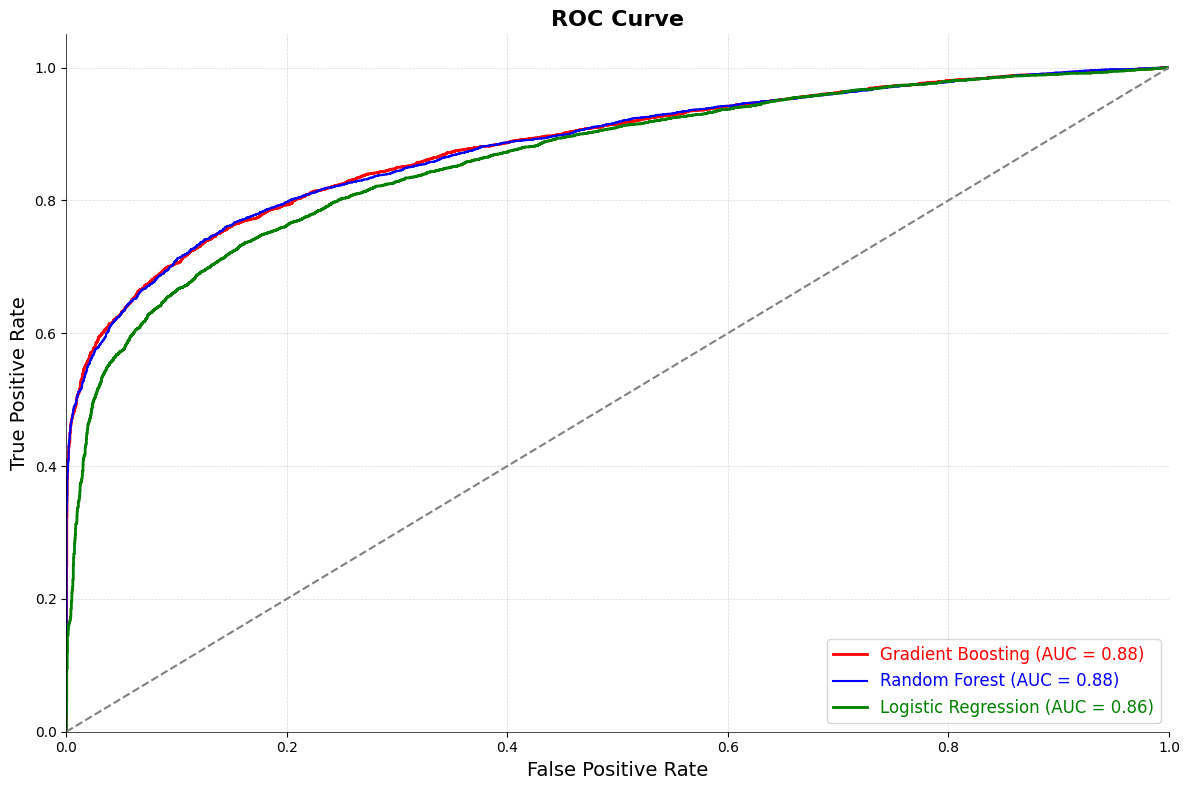

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# For RF
y_prob_rf = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# For GB
y_prob_gb = gb.predict_proba(X_test)[:,1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
auc_gb = auc(fpr_gb, tpr_gb)

# For LR
y_prob_lr = sigmoid(np.dot(X_test, initial_coeffs))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(12, 8))

# Plot ROC curves with the AUC incorporated into the label
plt.plot(fpr_gb, tpr_gb, color='red', lw=2, label=f'Gradient Boosting (AUC = {auc_gb:.2f})')
plt.plot(fpr_rf, tpr_rf, color='blue', lw=1.5, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16, fontweight='bold')

# Improve spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Add grid
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Position the legend at the specified location
legend = plt.legend(loc='lower right', fontsize=12)

# Color the legend text based on the line color
for line, text in zip(legend.get_lines(), legend.get_texts()):
    text.set_color(line.get_color())

plt.tight_layout()
plt.show()

In [ ]:
import sys
import time
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Gradient Boosting
gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=4, min_samples_leaf=50, n_estimators=240, random_state=42)

# Measure training time
start_time = time.time()
gb.fit(X_train, y_train)
gb_train_time = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_pred_gb = gb.predict(X_test)
gb_pred_time = time.time() - start_time

# Measure memory usage
gb_memory = sys.getsizeof(gb)

print('Gradient Boosting accuracy:', accuracy_score(y_test, y_pred_gb))
print('Gradient Boosting training time:', gb_train_time, 'seconds')
print('Gradient Boosting prediction time:', gb_pred_time, 'seconds')
print('Gradient Boosting memory usage:', gb_memory, 'bytes')

Gradient Boosting accuracy: 0.8022090407036204
Gradient Boosting training time: 13.518351554870605 seconds
Gradient Boosting prediction time: 0.054711341857910156 seconds
Gradient Boosting memory usage: 48 bytes


In [ ]:
# Random Forest
rf = RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42)

# Measure training time
start_time = time.time()
rf.fit(X_train, y_train)
rf_train_time = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_pred_rf = rf.predict(X_test)
rf_pred_time = time.time() - start_time

# Measure memory usage
rf_memory = sys.getsizeof(rf)

print('Random Forest accuracy:', accuracy_score(y_test, y_pred_rf))
print('Random Forest training time:', rf_train_time, 'seconds')
print('Random Forest prediction time:', rf_pred_time, 'seconds')
print('Random Forest memory usage:', rf_memory, 'bytes')

Random Forest accuracy: 0.8024135815095111
Random Forest training time: 5.49162483215332 seconds
Random Forest prediction time: 0.46942973136901855 seconds
Random Forest memory usage: 48 bytes


Gradient Boosting accuracy: 0.8022090407036204
Gradient Boosting training time: 15.573853254318237 seconds
Gradient Boosting prediction time: 0.051081180572509766 seconds
Gradient Boosting memory usage: 48 bytes


In [ ]:
pip install numba shap

In [ ]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
def globalisation(the_model):
    # Using TreeExplainer for RandomForest
    explainer = shap.TreeExplainer(the_model)
    shap_values = explainer.shap_values(X_test)

    # plot the global feature importance
    shap.summary_plot(shap_values, X_test)

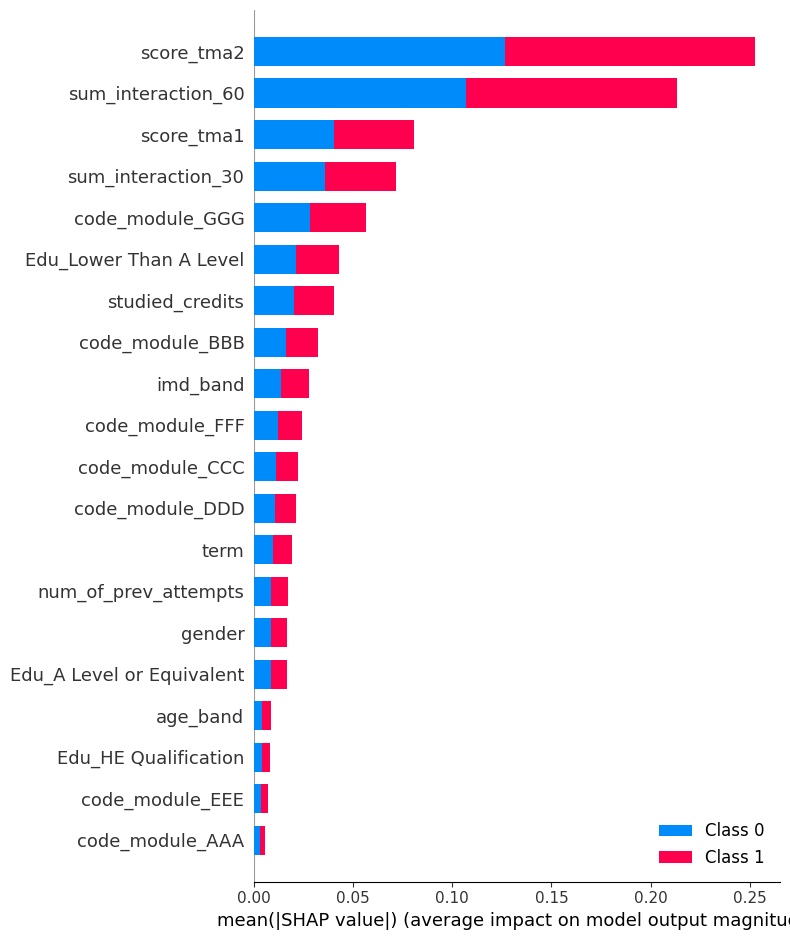

In [ ]:
globalisation(rf)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


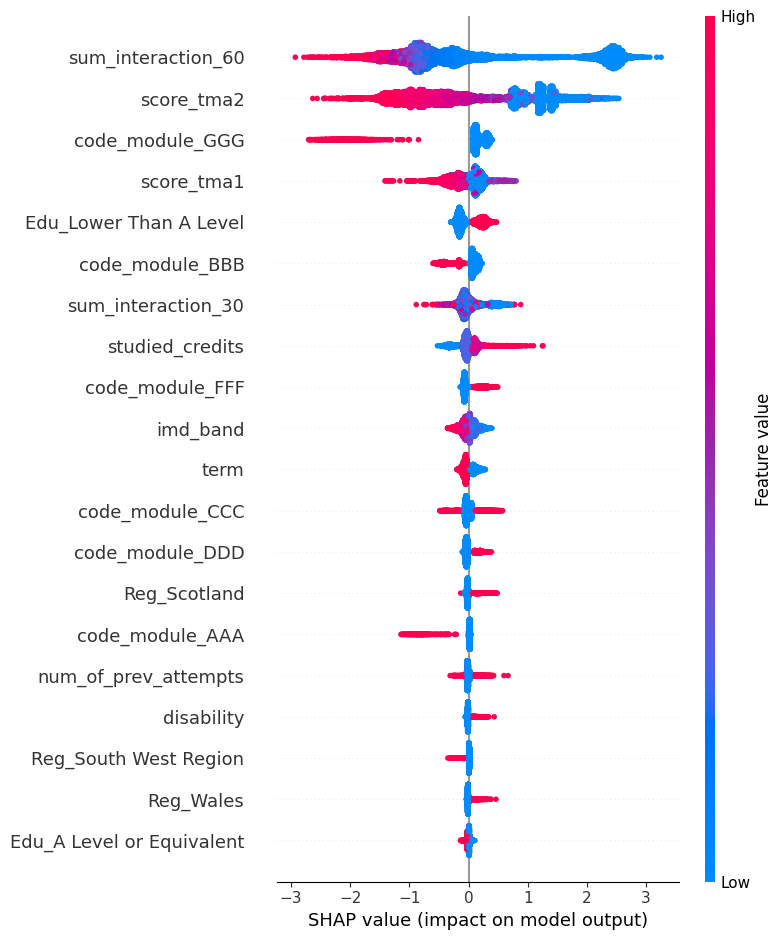

In [ ]:
globalisation(gb)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


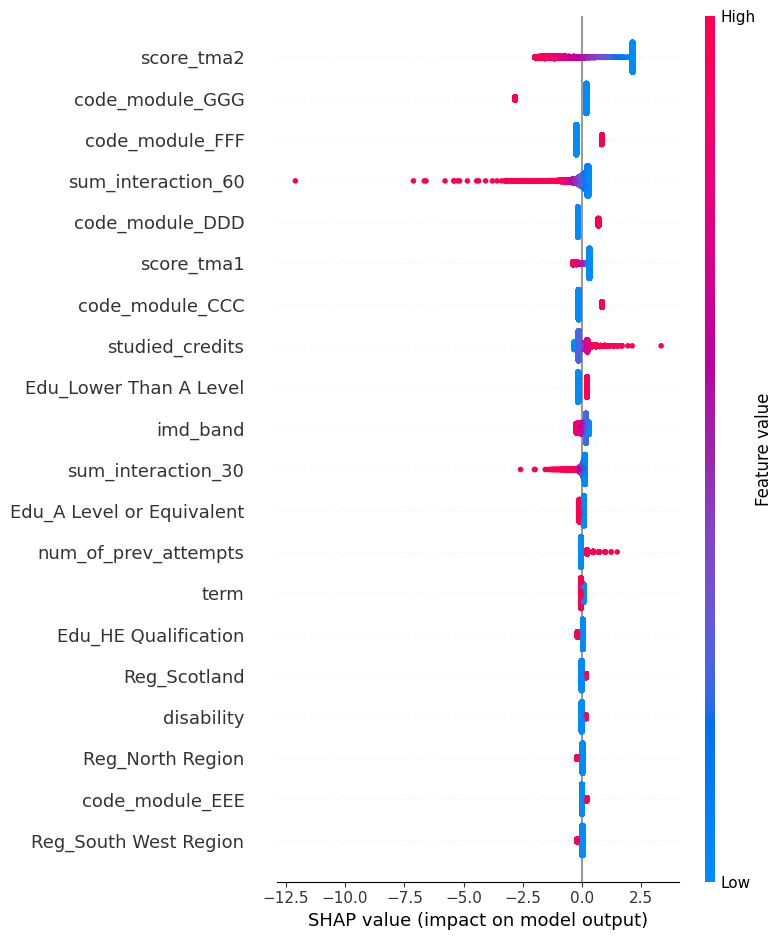

In [ ]:
# SHAP Explainer
explainer = shap.LinearExplainer(lr, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)

# Plot
shap.summary_plot(shap_values, X_test)

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=60c33d6bf6a945ff79be63a85ea1ffbf5e260bfdbaf74e14f34f5297c1cd9d2e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime


In [ ]:
# Define the start index
start_index = 545

# Loop through 10 instances starting from the start_index
for i in range(start_index, start_index + 10):
    actual_ground_truth = y_test.iloc[i]
    print(f"Instance {i}: ", end="")
    if actual_ground_truth == 0:
        print("Interpreted as: Pass")
    else:
        print("Interpreted as: At-Risk")

Instance 545: Interpreted as: At-Risk
Instance 546: Interpreted as: Pass
Instance 547: Interpreted as: Pass
Instance 548: Interpreted as: At-Risk
Instance 549: Interpreted as: Pass
Instance 550: Interpreted as: At-Risk
Instance 551: Interpreted as: Pass
Instance 552: Interpreted as: At-Risk
Instance 553: Interpreted as: At-Risk
Instance 554: Interpreted as: Pass


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Create a LIME explainer
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns,
                                 class_names=['Pass', 'At-Risk'], # Assume binary classification: Fail, Pass
                                 discretize_continuous=True)

# Explaining the prediction for the first instance in the test set:
exp = explainer.explain_instance(X_test.iloc[545].values, rf.predict_proba, num_features=15)
exp.show_in_notebook(show_all=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

# Train the Random Forest model
rf = RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Make predictions using the default threshold (0.5)
y_pred_rf = rf.predict(X_test)

# Print out accuracy and other metrics using the default threshold
print('Random Forest metrics (Default Threshold):')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Get the predicted probabilities for the "At-Risk" class
at_risk_probabilities = [prob[1] for prob in rf.predict_proba(X_test)]

# Use the custom threshold of 0.44 for "At-Risk"
threshold = 0.44
custom_predictions = [1 if prob > threshold else 0 for prob in at_risk_probabilities]

# Evaluate and print out metrics using the custom threshold
print('Random Forest metrics (Custom Threshold):')
print('Accuracy:', accuracy_score(y_test, custom_predictions))
print(classification_report(y_test, custom_predictions))

# ROC-AUC
roc_auc = roc_auc_score(y_test, at_risk_probabilities)
print('ROC-AUC Score:', roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, at_risk_probabilities)

Random Forest metrics (Default Threshold):
Accuracy: 0.8024135815095111
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      4558
           1       0.87      0.74      0.80      5220

    accuracy                           0.80      9778
   macro avg       0.81      0.81      0.80      9778
weighted avg       0.81      0.80      0.80      9778

Random Forest metrics (Custom Threshold):
Accuracy: 0.8004704438535488
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      4558
           1       0.83      0.79      0.81      5220

    accuracy                           0.80      9778
   macro avg       0.80      0.80      0.80      9778
weighted avg       0.80      0.80      0.80      9778

ROC-AUC Score: 0.8797775037448365


### Get fairness metrics out for the custom threshold

In [ ]:
def compute_fairness4(sensitive_feature, predictions):

  # Group data by the sensitive feature
  group_a = (X_test[sensitive_feature] == 1).values  # assuming 1 represents 'male' (modify as per your data)
  group_b = (X_test[sensitive_feature] == 0).values  # assuming 0 represents 'female' (modify as per your data)

  # Calculate ABROCA
  from holisticai.bias.metrics import abroca
  abroca_value = abroca(group_a, group_b, rf.predict_proba(X_test)[:, 1], y_test)
  print(f'ABROCA value: {abroca_value}')

  # Calculate Average Odds Difference
  from holisticai.bias.metrics import average_odds_diff
  aod_value = average_odds_diff(group_a, group_b, predictions, y_test)
  print(f'Average Odds Difference value: {aod_value}')

  # Calculate Equal Opportunity Difference
  from holisticai.bias.metrics import equal_opportunity_diff
  eod_value = equal_opportunity_diff(group_a, group_b, predictions, y_test)
  print(f'Equal Opportunity Difference value: {eod_value}')


In [ ]:
# Compute fairness metrics using the custom threshold
compute_fairness4('gender', custom_predictions)


ABROCA value: 0.016300690246065397
Average Odds Difference value: 0.026077248208637965
Equal Opportunity Difference value: 0.03405301806851213


In [ ]:
compute_fairness4('disability', custom_predictions)

ABROCA value: -0.010910234761777882
Average Odds Difference value: 0.06452900639833802
Equal Opportunity Difference value: 0.02588793250271848


In [ ]:
compute_fairness4('age_band', custom_predictions)

ABROCA value: -0.0039812586155256735
Average Odds Difference value: -0.05794268764659974
Equal Opportunity Difference value: -0.054319269273316984


In [ ]:
# Features of interest
features_of_interest = ['disability', 'gender', 'age_band',
                        'score_tma1', 'score_tma2', 'sum_interaction_30',
                        'sum_interaction_60']

# Modify the create_counterfactuals function with updated changes
def create_counterfactuals(instance):
    # 1. Flip gender
    flip_gender = instance.copy()
    flip_gender['gender'] = 1 - flip_gender['gender']

    # 2. Flip disability
    flip_disability = instance.copy()
    flip_disability['disability'] = 1 - flip_disability['disability']

    # 3. Flip age
    flip_age = instance.copy()
    flip_age['age_band'] = 1 - flip_age['age_band']

    # 4. Flip all three together
    flip_all_three = instance.copy()
    flip_all_three[['gender', 'disability', 'age_band']] = 1 - flip_all_three[['gender', 'disability', 'age_band']]

    # 5. Increase sum interactions by 500
    increase_interaction = instance.copy()
    increase_interaction['sum_interaction_30'] += 450
    increase_interaction['sum_interaction_60'] += 450

    # 6. Increase tma1 and tma2 by adding 20
    increase_tma_scores = instance.copy()
    increase_tma_scores['score_tma1'] += 0
    increase_tma_scores['score_tma2'] += 20

    return [flip_gender, flip_disability, flip_age, flip_all_three, increase_interaction, increase_tma_scores]

In [ ]:
# Updated create_table function
def create_table(instance, original_prediction, counterfactuals):
    # Start with original instance
    table = pd.DataFrame(columns=features_of_interest + ['final_result'])
    table.loc['Original'] = instance[features_of_interest].tolist() + [original_prediction]

    # Names for counterfactual strategies
    strategy_names = ["Flip Gender", "Flip Disability", "Flip Age", "Flip All Three",
                      "Increase Interactions", "Increase TMA Scores"]

    # Add counterfactual results to the table
    for i, (cf, strategy_name) in enumerate(zip(counterfactuals, strategy_names)):
        # Convert cf to DataFrame to fix warning
        df_cf = pd.DataFrame([cf], columns=X_train.columns)
        prediction = rf.predict(df_cf)
        table.loc[strategy_name] = df_cf[features_of_interest].values[0].tolist() + [prediction[0]]

    return table

# Specify instances you want to investigate using iloc
indices_to_investigate = [9007, 1506, 6382]
instances = X_test.iloc[indices_to_investigate]

# Get original predictions for these instances
original_predictions = rf.predict(instances)

# For each instance, create a table and display it
for i, (idx, instance) in enumerate(instances.iterrows()):
    counterfactuals = create_counterfactuals(instance)
    ground_truth = y_test.iloc[indices_to_investigate[i]]

    print(f"Table for Instance {idx} with Ground Truth final_result: {ground_truth}")
    table = create_table(instance, original_predictions[i], counterfactuals)
    display(table)
    print("\n")


Table for Instance 31445 with Ground Truth final_result: 1


,disability,gender,age_band,score_tma1,score_tma2,sum_interaction_30,sum_interaction_60,final_result
Original,0.0,0.0,1.0,0.0,0.0,11.0,0.0,1.0
Flip Gender,0.0,1.0,1.0,0.0,0.0,11.0,0.0,1.0
Flip Disability,1.0,0.0,1.0,0.0,0.0,11.0,0.0,1.0
Flip Age,0.0,0.0,0.0,0.0,0.0,11.0,0.0,1.0
Flip All Three,1.0,1.0,0.0,0.0,0.0,11.0,0.0,1.0
Increase Interactions,0.0,0.0,1.0,0.0,0.0,461.0,450.0,0.0
Increase TMA Scores,0.0,0.0,1.0,0.0,20.0,11.0,0.0,1.0




Table for Instance 26012 with Ground Truth final_result: 1


,disability,gender,age_band,score_tma1,score_tma2,sum_interaction_30,sum_interaction_60,final_result
Original,0.0,1.0,1.0,74.0,44.0,323.0,221.0,1.0
Flip Gender,0.0,0.0,1.0,74.0,44.0,323.0,221.0,1.0
Flip Disability,1.0,1.0,1.0,74.0,44.0,323.0,221.0,1.0
Flip Age,0.0,1.0,0.0,74.0,44.0,323.0,221.0,1.0
Flip All Three,1.0,0.0,0.0,74.0,44.0,323.0,221.0,1.0
Increase Interactions,0.0,1.0,1.0,74.0,44.0,773.0,671.0,0.0
Increase TMA Scores,0.0,1.0,1.0,74.0,64.0,323.0,221.0,0.0




Table for Instance 10706 with Ground Truth final_result: 1


,disability,gender,age_band,score_tma1,score_tma2,sum_interaction_30,sum_interaction_60,final_result
Original,0.0,1.0,0.0,0.0,78.0,91.0,20.0,1.0
Flip Gender,0.0,0.0,0.0,0.0,78.0,91.0,20.0,1.0
Flip Disability,1.0,1.0,0.0,0.0,78.0,91.0,20.0,1.0
Flip Age,0.0,1.0,1.0,0.0,78.0,91.0,20.0,1.0
Flip All Three,1.0,0.0,1.0,0.0,78.0,91.0,20.0,1.0
Increase Interactions,0.0,1.0,0.0,0.0,78.0,541.0,470.0,1.0
Increase TMA Scores,0.0,1.0,0.0,0.0,98.0,91.0,20.0,1.0


In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
# Features of interest as they are in the dataset
features_of_interest = ['disability', 'gender', 'age_band', 'score_tma1', 'score_tma2', 'sum_interaction_30', 'sum_interaction_60']

# Display names for columns
column_display_names = {
    'sum_interaction_30': 'clicks_30',
    'sum_interaction_60': 'clicks_60'
}

# Interpretation mappings
interpretations = {
    'gender': {0: 'Female', 1: 'Male'},
    'disability': {0: 'No', 1: 'Yes'},
    'age_band': {0: '0-35yrs', 1: '>=35yrs'},
    'final_result': {0: 'Pass',1: 'At-Risk'}
}

def interpret_values(row):
    for col in ['gender', 'disability', 'age_band']:
        row[col] = interpretations[col][row[col]]
    return row

def create_table(instance, original_prediction, counterfactuals):
    # Start with original instance
    table_columns = [column_display_names.get(f, f) for f in features_of_interest] + ['final_result']
    table = pd.DataFrame(columns=table_columns)
    table_display_values = [instance[feat] for feat in features_of_interest]
    table.loc['Original'] = table_display_values + [interpretations['final_result'][original_prediction]]

    # Names for counterfactual strategies
    strategy_names = ["Flip Gender", "Flip Disability", "Flip Age", "Flip All Three",
                      "Increase Interactions", "Increase TMA Scores"]

    # Add counterfactual results to the table
    for i, (cf, strategy_name) in enumerate(zip(counterfactuals, strategy_names)):
        df_cf = pd.DataFrame([cf], columns=X_train.columns)
        prediction = rf.predict(df_cf)
        cf_display_values = [df_cf[feat].values[0] for feat in features_of_interest]
        table.loc[strategy_name] = cf_display_values + [interpretations['final_result'][prediction[0]]]

    # Apply interpretation to the entire DataFrame for a more consistent display
    table = table.apply(interpret_values, axis=1)

    return table

# Now, let's focus solely on the instance 1506
instance = X_test.iloc[1506]
original_prediction = rf.predict([instance])[0]
counterfactuals = create_counterfactuals(instance)
ground_truth = y_test.iloc[1506]

print(f"Counterfactual Analysis for Student1506 with Model Predcition:  {interpretations['final_result'][ground_truth]}")
table = create_table(instance, original_prediction, counterfactuals)
display(table)

Counterfactual Analysis for Student1506 with Model Predcition:  At-Risk


,disability,gender,age_band,score_tma1,score_tma2,clicks_30,clicks_60,final_result
Original,No,Male,>=35yrs,74.0,44.0,323.0,221.0,At-Risk
Flip Gender,No,Female,>=35yrs,74.0,44.0,323.0,221.0,At-Risk
Flip Disability,Yes,Male,>=35yrs,74.0,44.0,323.0,221.0,At-Risk
Flip Age,No,Male,0-35yrs,74.0,44.0,323.0,221.0,At-Risk
Flip All Three,Yes,Female,0-35yrs,74.0,44.0,323.0,221.0,At-Risk
Increase Interactions,No,Male,>=35yrs,74.0,44.0,773.0,671.0,Pass
Increase TMA Scores,No,Male,>=35yrs,74.0,64.0,323.0,221.0,Pass


In [ ]:
# Now, let's focus solely on the instance 9002
instance = X_test.iloc[9002]
original_prediction = rf.predict([instance])[0]
counterfactuals = create_counterfactuals(instance)
ground_truth = y_test.iloc[9002]

print(f"Counterfactual Analysis for Student9002 with Model Predcition: {interpretations['final_result'][ground_truth]}")
table = create_table(instance, original_prediction, counterfactuals)
display(table)

Counterfactual Analysis for Student9002 with Model Predcition: At-Risk


,disability,gender,age_band,score_tma1,score_tma2,clicks_30,clicks_60,final_result
Original,No,Male,0-35yrs,76.0,58.0,527.0,80.0,At-Risk
Flip Gender,No,Female,0-35yrs,76.0,58.0,527.0,80.0,At-Risk
Flip Disability,Yes,Male,0-35yrs,76.0,58.0,527.0,80.0,At-Risk
Flip Age,No,Male,>=35yrs,76.0,58.0,527.0,80.0,At-Risk
Flip All Three,Yes,Female,>=35yrs,76.0,58.0,527.0,80.0,At-Risk
Increase Interactions,No,Male,0-35yrs,76.0,58.0,977.0,530.0,Pass
Increase TMA Scores,No,Male,0-35yrs,76.0,78.0,527.0,80.0,Pass
